In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, Conv3D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, AveragePooling3D, MaxPooling3D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import tarfile
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# 인터널 에러가 자주 떠서 알집파일이 하드 기본 경로에 있다고 치고 코드를 실행

In [2]:
tar = tarfile.open("cifar-100-python.tar.gz")
tar.extractall()
tar.close()

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')

In [5]:
# Training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 100

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3
depth = n * 6 + 2

In [6]:
train_data = train[b'data'].reshape(-1,3,32,32)
train_label_fine = np.array(train[b'fine_labels'])
train_label_coarse = np.array(train[b'coarse_labels'])

test_data = test[b'data'].reshape(-1,3,32,32)
test_label_fine = np.array(test[b'fine_labels'])
test_label_coarse = np.array(test[b'coarse_labels'])

print(train_data.shape)
print(train_label_fine.shape)
print(test_data.shape)
print(test_label_fine.shape)

(50000, 3, 32, 32)
(50000,)
(10000, 3, 32, 32)
(10000,)


In [7]:
x_train=train_data
x_test=test_data
y_train=train_label_fine
y_test=test_label_fine

In [8]:
r = x_train[:,0,:,:]
g = x_train[:,1,:,:]
b = x_train[:,2,:,:]
r2 = x_test[:,0,:,:]
g2 = x_test[:,1,:,:]
b2 = x_test[:,2,:,:]


In [9]:
aggRGB=np.empty([50000,32,32,3])
aggRGB2=np.empty([10000,32,32,3])

In [10]:
aggRGB[:,:,:,0] = r
aggRGB[:,:,:,1] = g
aggRGB[:,:,:,2] = b

aggRGB2[:,:,:,0] = r2
aggRGB2[:,:,:,1] = g2
aggRGB2[:,:,:,2] = b2

In [11]:
x_train = aggRGB
x_test = aggRGB2

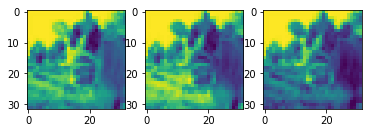

In [12]:
# show data
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
sample_data = x_train[0]
ax1.imshow(sample_data[:,:,0]);
ax2.imshow(sample_data[:,:,1]);
ax3.imshow(sample_data[:,:,2]);


In [13]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train = x_train.astype('float64')
    x_train -= x_train_mean
    x_test = x_test.astype('float64')
    x_test -= x_train_mean
    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000,)


In [14]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

In [15]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [16]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 1e-4
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [17]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-3)
                 )

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [18]:
def resnet_v1(input_shape, depth, num_classes=100):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    
#     x = AveragePooling2D(pool_size=16)(x)
    
#     x = MaxPooling3D(pool_size=(2, 2, 2), strides=None, padding='valid', data_format=None)(x)
    
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [20]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 522us/step
Test loss: 17.487594271850586
Test accuracy: 0.0136
